In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [47]:
#!/usr/bin/env python
# coding: utf-8

#phi - simple LSTM


import csv
def readCSV(fileName,r):
    sent = []
    with open(fileName) as file:
        readcsv = csv.reader(file, delimiter=',')
        for row in readcsv:
            sentence = row[r]
            sent.append(sentence)
    return sent

# In[5]:

neg = readCSV('../../corpora/verified_non_analogies.csv',1)
pos = readCSV('../../corpora/verified_analogies.csv',1)
labels = [1]*len(pos) + [0] * len(neg)
texts = pos + neg
texts = [t.replace("like","") for t in texts]

# In[66]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 28 #maximum allowed number of words in a sentence 

max_words = 10000#choosing the most 10000 common words
test = 40 #number of testing samples

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found {} unique tokens".format(len(word_index)))

data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)

indices = np.arange(data.shape[0])

np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

train_data = data[:len(data)-test]
test_data = data[len(data)-test:]
train_targets = labels[:len(data) - test]
test_targets = labels[len(data)-test:]

print("Shape of data ", data.shape)
print("Shape of label", labels.shape)
print("Shape of train_data", train_data.shape)
print("Shape of test_data", test_data.shape)
print("Shape of train_targets", train_targets.shape)
print("Shape of test_targets", test_targets.shape)

embedding_index = {}

#download glove before this
f = open("../../glove/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()

print("Found {} words".format(len(embedding_index)))

import numpy as np
k = 4 # 4 k-fold
num_val_samples = len(train_data) // k
num_epochs = 10


# Embed sentences

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

def build_model():
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
    model.add(LSTM(32))
    model.add(Dense(1, activation = 'sigmoid'))
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
    model.save_weights('pre_trained_glove_model.h5')
    return model

#k-fold training
val_acc_history = []
acc_history = []
for i in range(k):
    print('processing fold: #',i)
    val_data = train_data[i * num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]], axis = 0)
    
    partial_test_data = np.concatenate(
    [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]], axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_test_data, epochs = num_epochs, batch_size = 1, verbose = 0,
                       validation_data = (val_data, val_targets))
    val_acc = history.history['val_acc']
    acc = history.history['acc']
    val_acc_history.append(val_acc)
    acc_history.append(acc)

results = model.evaluate(test_data, test_targets)




Found 2793 unique tokens
Shape of data  (316, 28)
Shape of label (316,)
Shape of train_data (276, 28)
Shape of test_data (40, 28)
Shape of train_targets (276,)
Shape of test_targets (40,)
Found 400000 words
processing fold: # 0
processing fold: # 1
processing fold: # 2
40/40 [==============================] - 0s 417us/step


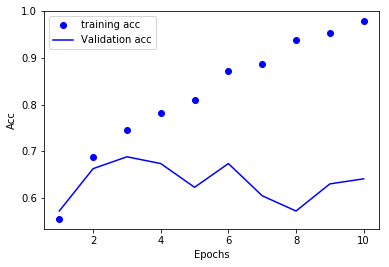

In [48]:
avg_acc_history = [np.mean([x[i] for x in acc_history] ) for i in range(num_epochs)]
avg_val_acc_history = [np.mean([x[i] for x in val_acc_history] ) for i in range(num_epochs)]
import matplotlib.pyplot as plt
plt.plot(range(1, len(avg_acc_history) + 1), avg_acc_history, 'bo', label = 'training acc')
plt.plot(range(1, len(avg_val_acc_history) + 1), avg_val_acc_history, 'b', label = 'Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [49]:
results

[1.1449997663497924, 0.7]

In [41]:
train_targets

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1])

In [43]:
texts

['and yet  a child among adults .',
 "I don't mean a few aesthetes who play about with sensations ,  a young prince in a miniature dabbling his hand in a pool .",
 'Oh , he was being queer and careful , pawing about in the drawer and holding the bottle  a snake at the length of his arm .',
 '`` I went to the city And there I did Weep , Men a-crowing  asses , And living  sheep .',
 'Rumor of a big battle spread  a grassfire up the valley .',
 'When the sun came out , Stevie strode proudly into Orange Square , smiling  a landlord on industrious tenants .',
 'They gave the room a strange note of incongruity ,  a mole on a beautiful face .',
 'It always came on , faithfully , just  a radio or juke box , whenever he started to worry too much about something , when the bad things tried to push their way into him .',
 'The design of a mechanical interlocking frame is much  a mechanical puzzle , but once understood , the principles can be applied to any track and signal arrangement .',
 'The s